### BCGx Challenge 2023 - Proposta de Solução - Grupo 13
> Membros: Henrique Caetano, Milla Pereira, Lara Tagarro e Thamya Donadia.



#### 1. Bibliotecas e utilidades

In [153]:
import pandas as pd
import numpy as np

# Para retirar os acentos das palavras
from unidecode import unidecode 

# Para calcular as distâncias
from geopy.distance import geodesic 

# Para PCA, normalização, cluster 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Para visualização 
import seaborn as sns
import matplotlib.pyplot as plt


In [145]:
# Código UF e estado
sigla_uf = {
    21: 'MA',
    22: 'PI',
    23: 'CE',
    24: 'RN',
    25: 'PB',
    26: 'PE',
    27: 'AL',
    28: 'SE',
    29: 'BA'
}   

estados_nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']

codigo_municipios_AdB = [2308104, 2607000, 2602803, 2708402]

# Para formatar tabelas
def remover_acentos(texto):
    return unidecode(texto)

# Lidar com a desigualdade na economia
def corte_de_recursos(value):
    if(value > 20):
        value = 20
    return value

# Municípios que a ONG já atua 
cases_de_sucesso = {
    "INAJA":   2607000,
    "TAPERA":  2708402,
    "MAURITI": 2308104, 
    "BUIQUE":  2602803}

# Retira colunas totalmente nulas 
def null_tratamento_tabela(tabela):
    tabela.dropna(axis=1, how="all", inplace=True)
    tabela.dropna(axis=0, how="all", inplace=True)

# Tranforma tudo que não é número em zero
colunas_mantidas_pam = ['MUNICIPIO', 'UF']

def transforma_para_zero(valor, col_name):
    if col_name in colunas_mantidas_pam:
        return valor
    try:
        return float(valor)
    except (ValueError, TypeError):
        return 0   
    
# Coordenadas dos municípios com CTs
pontos_referencia = {
    'BUIQUE': (-8.61954, -37.1606),
    'MAURITI': (-7.38597, -38.7708),
    'INAJA': (-8.90206, -37.8351),
    'TAPERA': (-9.55768, -37.3831 )
}

# Função para calcular a distância entre o ponto de referência e cada cidade
def calcular_distancia(linha, ponto_referencia):
    coordenadas = (linha['LATITUDE'], linha['LONGITUDE'])
    return geodesic(ponto_referencia, coordenadas).kilometers

#### 2. Leitura e tratamento dos dados

##### 2.1 Registros Administrativos

In [3]:
df_registros_total = pd.read_excel('./Dados/Registros Administrativos/dados_registros_administrativos_total_2012_2017.xlsx', sheet_name='MUNICÍPIO')

# Criando coluna com siglas dos estados
df_registros_total['UF'] = df_registros_total['IBGE7'].astype(str).str[:2].astype(int).map(sigla_uf)

# Filtrando cidades fora do sertão
df_registros_total = df_registros_total[~pd.isnull(df_registros_total['UF'])]

# Trocando o nome da coluna de cidade
df_registros_total = df_registros_total.rename(columns={'NOME':'MUNICIPIO'})

# Removendo acentos e passando pra maíusculo
df_registros_total['MUNICIPIO'] = df_registros_total['MUNICIPIO'].apply(remover_acentos)
df_registros_total['MUNICIPIO'] = df_registros_total['MUNICIPIO'].str.upper()

df_registros_total = df_registros_total.drop(columns=['DESAGREGACAO'])

display(df_registros_total)

,ANO,IBGE7,MUNICIPIO,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,PMATPRI_EM,DIST_EF_TOTAL,DIST_EM_TOTAL,DIST_EF_PRI,...,PFOCOS,PFLORA,PFEM_VEREADOR,PFEM_PREFEITO,PFEM_GOVERNADOR,PFEM_DEP_ESTADUAL,PFEM_DEP_FEDERAL,PFEM_SENADOR,POP_TOT,UF
450,2013,2100055,ACAILANDIA,90.81,92.62,9.19,7.38,20.7,36.0,3.1,...,1.20,36.22,17.65,100.0,NaN,NaN,NaN,NaN,107790,MA
451,2013,2100105,AFONSO CUNHA,100.00,100.00,NaN,NaN,36.7,58.8,NaN,...,0.12,94.39,22.22,0.0,NaN,NaN,NaN,NaN,6197,MA
452,2013,2100154,AGUA DOCE DO MARANHAO,99.20,100.00,0.80,NaN,25.7,55.6,NaN,...,0.23,87.75,11.11,0.0,NaN,NaN,NaN,NaN,12028,MA
453,2013,2100204,ALCANTARA,98.96,100.00,1.04,NaN,28.6,49.0,NaN,...,0.13,70.16,9.09,0.0,NaN,NaN,NaN,NaN,21644,MA
454,2013,2100303,ALDEIAS ALTAS,98.90,100.00,1.10,NaN,37.9,48.3,4.7,...,0.33,93.73,27.27,0.0,NaN,NaN,NaN,NaN,25177,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24519,2017,2933307,VITORIA DA CONQUISTA,73.68,84.19,26.32,15.81,32.2,40.0,7.5,...,0.13,28.75,14.29,0.0,NaN,NaN,NaN,NaN,348718,BA
24520,2017,2933406,WAGNER,93.82,100.00,6.18,NaN,21.6,35.9,4.8,...,0.01,50.22,0.00,0.0,NaN,NaN,NaN,NaN,9753,BA
24521,2017,2933455,WANDERLEY,95.36,100.00,4.64,NaN,22.7,33.6,1.1,...,0.19,64.16,22.22,100.0,NaN,NaN,NaN,NaN,12935,BA
24522,2017,2933505,WENCESLAU GUIMARAES,97.36,100.00,2.64,NaN,45.0,56.6,3.0,...,0.03,69.08,18.18,0.0,NaN,NaN,NaN,NaN,22365,BA


##### 2.2 Municípios do Sertão 

In [55]:
# Dataframe com todos os municípios
df_mun = pd.read_csv('./Dados/Municipios/municipios.csv') 

# Municípios do sertão nordestino
df_mun_sertao = pd.read_excel("./Dados/Municipios/lista-1262municipios-semiarido-2017.xlsx", skiprows=2, usecols=list(range(1,4)))

df_mun = df_mun.rename(columns={'codigo_ibge':'IBGE7',
                                'latitude':'LATITUDE',
                                'longitude':'LONGITUDE',
                                'codigo_uf':'UF',
                                'nome':'MUNICIPIO'})

df_mun_sertao = df_mun_sertao.rename(columns={'Cod IBGE': 'IBGE7',
                                              'Município': 'MUNICIPIO',
                                              'Populacao_estimada_2017': 'POPULACAO_ESTIMADA_2017'})

# Tirando municípios de outros estados e adicionando cod_uf
filtro1 = (df_mun['UF'] >= 21) & (df_mun['UF'] <= 29)
filtro2 = df_mun_sertao['UF'].isin(estados_nordeste)

df_mun = df_mun[filtro1].copy()
df_mun_sertao = df_mun_sertao[filtro2].copy()
df_mun['UF'] = df_mun['UF'].map(sigla_uf)

# Tratando colunas
df_mun['MUNICIPIO'] = df_mun['MUNICIPIO'].apply(remover_acentos)
df_mun_sertao['MUNICIPIO'] = df_mun_sertao['MUNICIPIO'].apply(remover_acentos)

df_mun['MUNICIPIO'] = df_mun['MUNICIPIO'].str.upper()
df_mun_sertao['MUNICIPIO'] = df_mun_sertao['MUNICIPIO'].str.upper()

# Juntando os dados das duas colunas
df_mun_sertao = df_mun_sertao.merge(df_mun, on=['IBGE7'], how='left')

# Filtrar as linhas em que 'município' é diferente
df_diferentes = df_mun_sertao[df_mun_sertao['MUNICIPIO_x'] != df_mun_sertao['MUNICIPIO_y']]

df_mun_sertao.drop(columns=['MUNICIPIO_y', 'UF_y'], inplace=True)
df_mun_sertao = df_mun_sertao.rename(columns={'MUNICIPIO_x': 'MUNICIPIO', 'UF_x': 'UF'})

##### 2.3 Produção Agrícola Municipal (PAM)

In [146]:
df_pam_colhida = pd.read_csv('./Dados/PAM/pam_area_colhida.csv', sep=';', skiprows=4, skipfooter=35, engine="python")
df_pam_plantada = pd.read_csv('./Dados/PAM/pam_area_plantada.csv', sep=';', skiprows=4, skipfooter=35, engine="python")

# Tratamento do nome das colunas
df_pam_colhida.columns = df_pam_colhida.columns.str.upper()
df_pam_plantada.columns = df_pam_plantada.columns.str.upper()

# Criação da coluna de "Muncípios" e "UF", a partir da coluna "Brasil e Município"
df_pam_colhida[['MUNICIPIO', 'UF']] = df_pam_colhida['BRASIL E MUNICÍPIO'].str.split(' \(', expand=True)
df_pam_colhida['UF'] = df_pam_colhida['UF'].str.rstrip(')')
df_pam_plantada[['MUNICIPIO', 'UF']] = df_pam_plantada['BRASIL E MUNICÍPIO'].str.split(' \(', expand=True)
df_pam_plantada['UF'] = df_pam_plantada['UF'].str.rstrip(')')

# Retirada dos municípios fora do Nordeste 
filtro3 = df_pam_colhida['UF'].isin(estados_nordeste)
filtro4 = df_pam_plantada['UF'].isin(estados_nordeste)

df_pam_colhida = df_pam_colhida[filtro3]
df_pam_plantada = df_pam_plantada[filtro4]

# Padronização dos conteúdos da coluna de município 
df_pam_colhida['MUNICIPIO'] = df_pam_colhida['MUNICIPIO'].apply(remover_acentos)
df_pam_colhida['MUNICIPIO'] = df_pam_colhida['MUNICIPIO'].str.upper()
df_pam_plantada['MUNICIPIO'] = df_pam_plantada['MUNICIPIO'].apply(remover_acentos)
df_pam_plantada['MUNICIPIO'] = df_pam_plantada['MUNICIPIO'].str.upper()

df_pam_colhida = df_pam_colhida.drop('BRASIL E MUNICÍPIO', axis=1)
df_pam_plantada = df_pam_plantada.drop('BRASIL E MUNICÍPIO', axis=1)

# Tranformando símbolos em número zero, e os números em valor númerico
for col in df_pam_colhida.columns:
  df_pam_colhida[col] = df_pam_colhida.apply(lambda row: transforma_para_zero(row[col], col), axis=1)

for col in df_pam_plantada.columns:
  df_pam_plantada[col] = df_pam_plantada.apply(lambda row: transforma_para_zero(row[col], col), axis=1)


##### 2.4 Agência Nacional de Águas (ANA)

In [25]:
df_ana_mun = pd.read_excel('./Dados/ANA/Atlas Irrigacao - Area Atual e Potencial.xlsx', sheet_name='Atlas_mun', skiprows=6, usecols=list(range(1, 20)))

# Tratamento do nome das colunas
df_ana_mun.columns = df_ana_mun.columns.str.upper()
df_ana_mun = df_ana_mun.rename(columns={"CÓDIGO":  "IBGE7"})

# Filtrando cidades do sertão
filtro5 = df_ana_mun['UF'].isin(estados_nordeste)
df_ana_mun = df_ana_mun[filtro5]


##### 2.5 Censo 

In [26]:
df_censo = pd.read_excel('./Dados/Censo/Censo_municipal_estadual_nacional.xlsx', sheet_name='MUN 91-00-10')

# Tratamento do nome das colunas
df_censo = df_censo.rename(columns={'Codmun7':'IBGE7'})
df_censo.columns = df_censo.columns.str.upper()

#### 3. Construção da matriz de mapeamento dos dados 

In [57]:
matriz = df_mun_sertao.copy()

df_censo_resumido = df_censo.copy()
df_ana_mun_resumido = df_ana_mun.copy()
df_registros_total_resumido = df_registros_total.copy()


##### 3.1 Tratamento do Censo para a matriz 

In [58]:
# Retirando colunas completamente nulas
null_tratamento_tabela(df_censo_resumido)

# Retirando linhas de 1991
df_censo_resumido = df_censo_resumido[df_censo_resumido['ANO'] != 1991]

# Filtrando as colunas de interesse
colunas_para_manter_censo = ['IBGE7', 'ANO','ESPVIDA', 'MORT1', 'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24', 'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'PIND', 'PINDCRI', 'PMPOB', 'PMPOBCRI', 'PPOB', 'PPOBCRI', 'GINI', 'PRENTRAB', 'RDPC', 'THEIL', 'P_AGRO', 'P_COM', 'P_CONSTR', 'P_EXTR', 'P_SERV', 'T_AGUA', 'AGUA_ESGOTO', 'T_FORA4A5', 'T_FORA6A14', 'T_FUNDIN_TODOS_MMEIO', 'T_NESTUDA_NTRAB_MMEIO', 'T_SLUZ', 'I_ESCOLARIDADE', 'I_FREQ_PROP', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']
df_censo_resumido = df_censo_resumido[colunas_para_manter_censo]

# Colocando as cidade como index
df_censo_resumido = df_censo_resumido.set_index('IBGE7')
df_censo_resumido = df_censo_resumido.pivot(columns='ANO')

# Renomeia as colunas para incluir o nome da coluna original e o ano correspondente
df_censo_resumido.columns = [f'{coluna}_{ano}' for coluna, ano in df_censo_resumido.columns]

# Redefine o índice do novo DataFrame para 'IBGE7'
df_censo_resumido.index.name = 'IBGE7'

# União das informações de município com as de censo
matriz = matriz.merge(df_censo_resumido, on=['IBGE7'], how='left')

##### 3.2 Tratamento do ANA para a matriz 

In [60]:
descarte_colunas_ana = range(1,16)

# Mantendo apenas colunas de interesse
df_ana_mun_resumido = df_ana_mun_resumido.drop(df_ana_mun_resumido.columns[descarte_colunas_ana], axis=1)

# Adicionando informações de irrigação à matriz
matriz = matriz.merge(df_ana_mun_resumido, on=['IBGE7'], how='left')

#### 4. Clusterização

In [66]:
colunas_retirar_matriz = [1, 2, 3, 4, 4]

# Retirando colunas com informações não relevantes para o cluster 
matriz_cluster = matriz.drop(matriz.columns[colunas_retirar_matriz], axis=1)
matriz_cluster = matriz_cluster.set_index('IBGE7')

##### 4.1 Normalização dos valores  

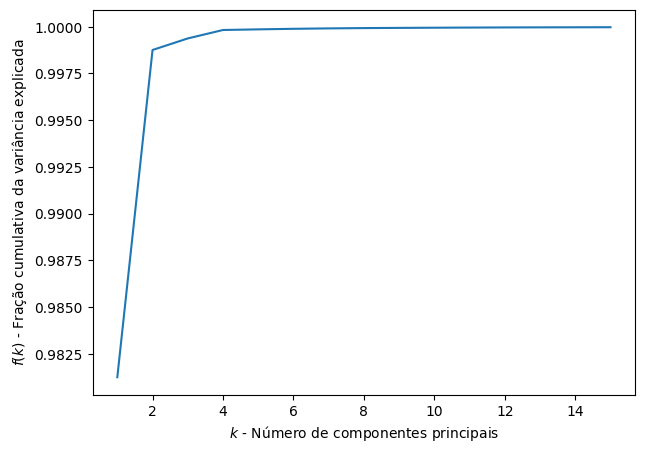

In [72]:
# Verificando quantidade de componentes principais na matriz
pca = PCA(n_components = 15)
pca.fit(matriz_cluster);

fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

In [75]:
# Normalização dos valores 
colunas_numericas = matriz_cluster.select_dtypes(include='number')
scaler = MinMaxScaler()
matriz_cluster[colunas_numericas.columns] = scaler.fit_transform(colunas_numericas)

##### 4.2 Clusterização  

In [80]:
n = 5
kmeans = KMeans(n_clusters=n, random_state=0)
kmeans.fit(matriz_cluster)
matriz_cluster['CLUSTER'] = kmeans.labels_

/home/thamya/projects/bcg/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


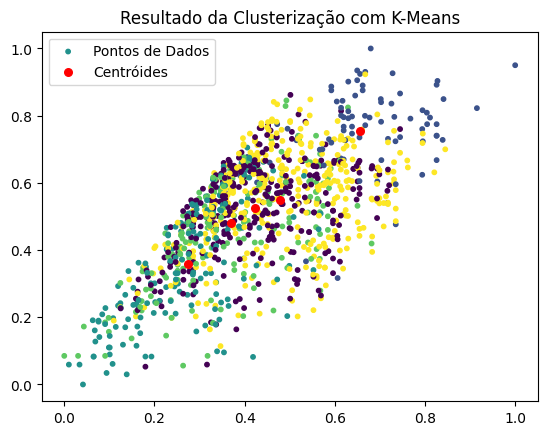

In [81]:
# Definindo os centros 
centros = kmeans.cluster_centers_

matriz_plot = matriz_cluster.to_numpy()  # Converte o DataFrame em uma matriz NumPy

plt.scatter(matriz_plot[:, 0], matriz_plot[:, 1], c=kmeans.labels_, s=10, cmap='viridis')
plt.scatter(centros[:, 0], centros[:, 1], c='red', s=30)

plt.title('Resultado da Clusterização com K-Means')
plt.legend(['Pontos de Dados', 'Centróides'])

plt.show()

In [92]:
# Pegando as informações de coordenadas e cluster para plotar o gráfico
matriz_aux = matriz[['IBGE7', 'LATITUDE', 'LONGITUDE']]
matriz_aux2 = matriz_cluster[['CLUSTER']]
matriz_aux = matriz_aux.merge(matriz_aux2, on=['IBGE7'], how='inner')

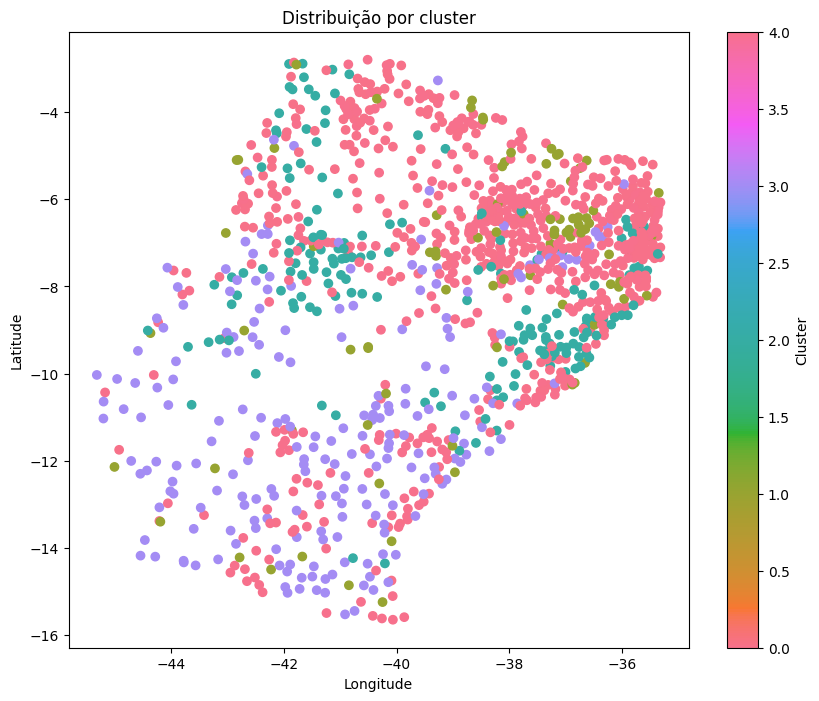

In [95]:
# Paleta de cor
paleta = sns.color_palette("husl", as_cmap=True)

# Gráfico
plt.figure(figsize=(10, 8))
plt.scatter(matriz_aux['LONGITUDE'], matriz_aux['LATITUDE'], c=matriz_aux['CLUSTER'], cmap=paleta)
plt.title('Distribuição por cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Legenda
legend = plt.colorbar()
legend.set_label('Cluster')

plt.show()

#### 5. Análise dos resultados

In [99]:
# Verificandos os cluters das cidades com CT
matriz_analise = matriz_aux.copy()
selecao = matriz_analise[matriz_analise['IBGE7'].isin(codigo_municipios_AdB)][['IBGE7', 'CLUSTER']]

print(selecao)

       IBGE7  CLUSTER
35   2708402        2
419  2308104        0
706  2602803        2
737  2607000        2


##### 5.1 Corte dos municípios por distância  

In [107]:
matriz_distancia = matriz_analise.copy()

# Obtendo apenas os municípios do cluster 2
matriz_distancia = matriz_distancia[matriz_distancia["CLUSTER"] == 2]

# Itera sobre os pontos de referência e calcule a distância para cada cidade
for nome_ponto, coordenadas_ponto in pontos_referencia.items():
    nome_coluna = f'DISTANCIA_{nome_ponto}'
    matriz_distancia[nome_coluna] = matriz_distancia.apply(calcular_distancia, args=(coordenadas_ponto,), axis=1)


In [113]:
# Retirando os municípios com distância abaixo de 60km de algum CT
matriz_distancia = matriz_distancia[(matriz_distancia["DISTANCIA_BUIQUE"]>60) & (matriz_distancia["DISTANCIA_MAURITI"]>60) & (matriz_distancia["DISTANCIA_INAJA"]>60) & (matriz_distancia["DISTANCIA_TAPERA"]>60)]

# Limite superior de corte: maior distância entre os CTs já existentes até Buique 
distancias_ate_buique = []

for ct in pontos_referencia:
    coordenadas = (pontos_referencia[ct])
    distancias_ate_buique.append(geodesic(pontos_referencia["BUIQUE"], coordenadas).kilometers)

maior_distancia = max(distancias_ate_buique)
print(f"Maior distância de um CT até Buique: {maior_distancia}")

matriz_distancia = matriz_distancia[matriz_distancia["DISTANCIA_BUIQUE"] < maior_distancia]
display(matriz_distancia)


Maior distância de um CT até Buique: 223.87921363832578


,IBGE7,LATITUDE,LONGITUDE,CLUSTER,DISTANCIA_BUIQUE,DISTANCIA_MAURITI,DISTANCIA_INAJA,DISTANCIA_TAPERA
7,2702009,-9.63348,-36.5845,2,128.787347,346.011691,159.454743,88.064056
8,2702355,-9.61780,-36.7697,2,118.475954,330.858363,141.317572,67.663348
11,2702553,-9.39089,-36.7644,2,95.791813,313.040689,129.509030,70.400042
12,2702900,-9.88404,-36.8316,2,144.453977,349.116551,154.740676,70.464992
13,2703106,-9.53768,-36.6372,2,116.716458,334.400308,149.233631,81.920422
17,2704104,-9.83291,-36.7413,2,141.891426,350.909114,158.224726,76.728395
21,2705309,-9.31236,-36.8696,2,83.040330,298.732788,115.427462,62.582249
37,2709202,-9.96262,-37.0071,2,149.503268,344.791228,148.420564,60.892942
113,2909208,-10.28470,-37.9198,2,202.164983,333.987060,153.209506,99.652013
175,2918100,-10.06850,-38.3471,2,206.568967,300.328244,140.730988,119.898671


##### 5.2 Corte dos municípios IDHM e população total  

In [125]:
municipios_sertao = df_mun_sertao["IBGE7"]

# Utilizando apenas o ano de 2010 e municipios do sertão
censo_ano_10 = df_censo['ANO'] == 2010
censo_sertao = df_censo['IBGE7'].isin(municipios_sertao)

# Obtendo o dataframe com as cidades ordenadas
df_censo_sertao = df_censo.loc[censo_sertao, :]
df_censo_sertao = df_censo_sertao.sort_values(by='MUNICÍPIO')

df_censo_sertao = df_censo_sertao.loc[censo_ano_10, ['ANO',"MUNICÍPIO", "IDHM", "PESOTOT",'IBGE7']]

# Tabela com municipios do sertão, seus idh's e população
display(df_censo_sertao)

,ANO,MUNICÍPIO,IDHM,PESOTOT,IBGE7
12020,2010,ABAIARA,0.628,10496,2300101
12957,2010,ABARÉ,0.575,17064,2900207
12956,2010,ABAÍRA,0.603,8316,2900108
12021,2010,ACARAPE,0.606,15338,2300150
12022,2010,ACARAÚ,0.601,57551,2300200
...,...,...,...,...,...
12371,2010,ÁGUA BRANCA,0.572,9449,2500106
12960,2010,ÁGUA FRIA,0.550,15731,2900405
12207,2010,ÁGUA NOVA,0.616,2980,2400406
12599,2010,ÁGUAS BELAS,0.526,40235,2600500


In [128]:
# Utilizando o intervalo das cidades que a ong já atua
municipios_ong = df_censo_sertao['IBGE7'].isin(cases_de_sucesso.values())

# Tabela apenas com os municipios que a ong atua
df_mun_ong = df_censo_sertao.loc[municipios_ong,:]

display(df_mun_ong)

,ANO,MUNICÍPIO,IDHM,PESOTOT,IBGE7
12623,2010,BUÍQUE,0.527,52105,2602803
12670,2010,INAJÁ,0.523,19081,2607000
12128,2010,MAURITI,0.605,44240,2308104
12868,2010,SÃO JOSÉ DA TAPERA,0.527,30088,2708402


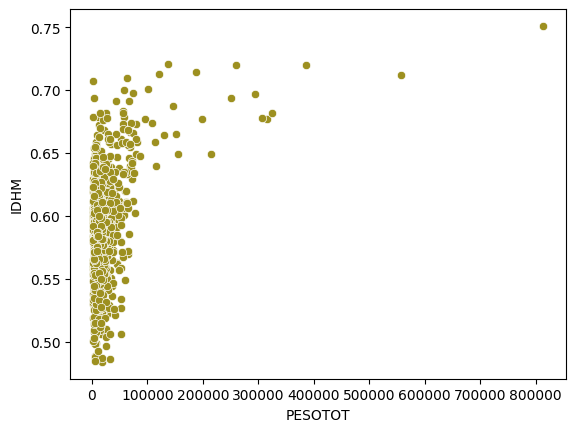

In [132]:
# Faixa de valor de IDH
menor_idh_ong = df_mun_ong['IDHM'].min() #0.523
maior_idh_ong = df_mun_ong['IDHM'].max() #0.605

graph = sns.scatterplot(data=df_censo_sertao, x='PESOTOT', y='IDHM', color="#9d9020")

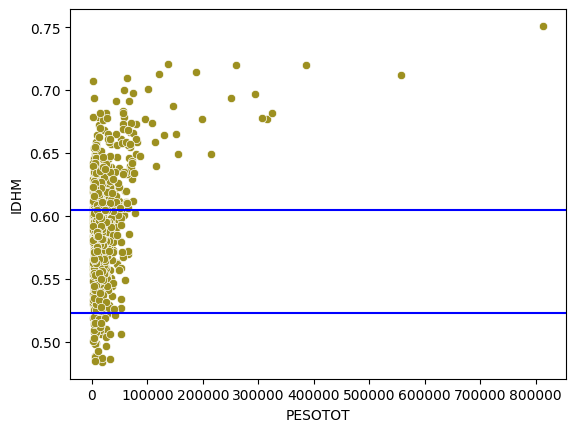

In [131]:
# Evidenciando o intervalo de IDH na distribuição
graph = sns.scatterplot(data=df_censo_sertao, x='PESOTOT', y='IDHM', color="#9d9020")
graph.axhline(menor_idh_ong, color="blue")
graph.axhline(maior_idh_ong, color="blue")

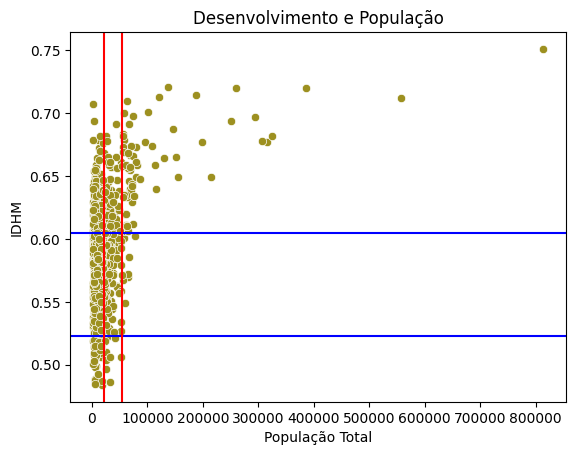

In [133]:
# Evidenciando os limites de população e de idh
graph = sns.scatterplot(data=df_censo_sertao, x='PESOTOT', y='IDHM', color="#9d9020")
graph.set_xlabel("População Total")
graph.set_title("Desenvolvimento e População")
graph.axhline(menor_idh_ong, color="blue")
graph.axhline(maior_idh_ong, color="blue")
graph.axvline(55000, color='red')
graph.axvline(22000, color='red')

##### 5.3 Retirando as cidades fora da zona de interesse

In [134]:
# Retirando cidades com idh fora da faixa de interesse
cidades_faixa_idhm = df_censo_sertao.loc[(df_censo_sertao['IDHM'] < maior_idh_ong) & (df_censo_sertao['IDHM'] > menor_idh_ong), :]

# Retirando cidades com população maior que a de interesse
df_cidades_potenciais = cidades_faixa_idhm.loc[(cidades_faixa_idhm['PESOTOT'] < 55000) & (cidades_faixa_idhm['PESOTOT'] > 22000), :]

# Verificando se os intervalos estão corretos
display(df_cidades_potenciais.sort_values(by='IDHM'))
display(df_cidades_potenciais.sort_values(by='PESOTOT'))

,ANO,MUNICÍPIO,IDHM,PESOTOT,IBGE7
12803,2010,CRAÍBAS,0.525,22641,2702355
12599,2010,ÁGUAS BELAS,0.526,40235,2600500
12623,2010,BUÍQUE,0.527,52105,2602803
12868,2010,SÃO JOSÉ DA TAPERA,0.527,30088,2708402
12933,2010,POÇO REDONDO,0.529,30880,2805406
...,...,...,...,...,...
12617,2010,BOM JARDIM,0.602,37826,2602209
13007,2010,BOQUIRA,0.603,22037,2904100
12156,2010,PEDRA BRANCA,0.603,41890,2310506
13263,2010,POÇÕES,0.604,44701,2925105


,ANO,MUNICÍPIO,IDHM,PESOTOT,IBGE7
13007,2010,BOQUIRA,0.603,22037,2904100
12760,2010,TACARATU,0.573,22068,2614808
12656,2010,FLORES,0.556,22169,2605608
12602,2010,ALTINHO,0.598,22353,2600807
13260,2010,PIRITIBA,0.578,22399,2924801
...,...,...,...,...,...
13349,2010,TUCANO,0.579,52418,2931905
12049,2010,BOA VIAGEM,0.598,52498,2302404
12083,2010,GRANJA,0.559,52645,2304707
12742,2010,SÃO BENTO DO UNA,0.593,53242,2613008


Text(0.5, 1.0, 'Cidades Potenciais')

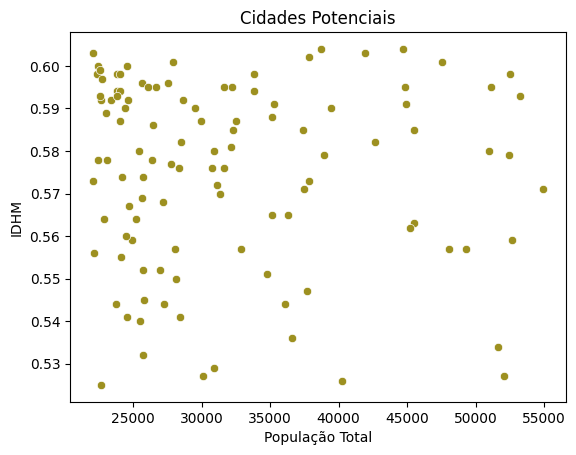

In [135]:
# Gráfico com as cidades potenciais
graph2 = sns.scatterplot(data=df_cidades_potenciais, x="PESOTOT", y='IDHM', color="#9d9020")
graph2.set_xlabel("População Total")
graph2.set_title("Cidades Potenciais")

##### 5.4 Unindo os dois filtros

In [136]:
# União dos dois dataframes para obter os municípios de interesse
uniao = df_cidades_potenciais['IBGE7'].isin(matriz_distancia['IBGE7'])
df_cidades_alvo = df_cidades_potenciais.loc[uniao,:]
display(df_cidades_alvo)

,ANO,MUNICÍPIO,IDHM,PESOTOT,IBGE7
12616,2010,BOM CONSELHO,0.563,45503,2602100
12633,2010,CANHOTINHO,0.541,24521,2603702
12803,2010,CRAÍBAS,0.525,22641,2702355
12810,2010,GIRAU DO PONCIANO,0.536,36600,2702900
12812,2010,IGACI,0.564,25188,2703106
13169,2010,JEREMOABO,0.547,37680,2918100
12710,2010,PANELAS,0.569,25645,2610202
12878,2010,TRAIPU,0.532,25702,2709202


Text(0.5, 1.0, 'Cidades Alvo')

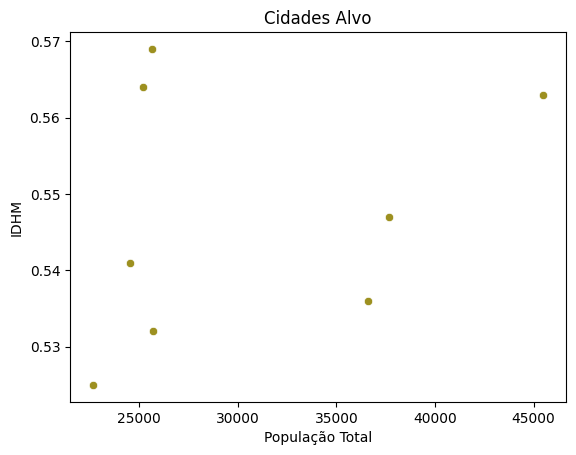

In [137]:
# Gráfico com as cidades alvo
graph3 = sns.scatterplot(data=df_cidades_alvo, x="PESOTOT", y='IDHM', color="#9d9020")
graph3.set_xlabel("População Total")
graph3.set_title("Cidades Alvo")

##### 5.5 Filtro pelo PAM

In [149]:
colunas_mantidas = ['CAJU', 'CAJU.1', 'CAJU.2', 'CASTANHA DE CAJU', 'CASTANHA DE CAJU.1', 'CASTANHA DE CAJU.2', 'MUNICIPIO', 'UF']

# Mantendo apenas colunas de interesse, ou seja, relacionados ao caju
df_pam_colhida_copia =  df_pam_colhida.drop(columns=[col for col in  df_pam_colhida.columns if col not in colunas_mantidas])
df_pam_plantada_copia =  df_pam_plantada.drop(columns=[col for col in  df_pam_plantada.columns if col not in colunas_mantidas])

# Filtrando cidades do sertão 
df_pam_colhida_copia = pd.merge(df_pam_colhida_copia, df_mun_sertao, on=['UF', 'MUNICIPIO'], how='inner')
df_pam_plantada_copia = pd.merge(df_pam_plantada_copia, df_mun_sertao, on=['UF', 'MUNICIPIO'], how='inner')


In [152]:
cidades_alvo = ['BOM CONSELHO', 'CANHOTINHO', 'CRAÍBAS', 'GIRAU DO PONCIANO', 'IGACI', 'JEREMOABO', 'PANELAS', 'TRAIPU']

df_pam_colhida_copia = df_pam_colhida_copia[df_pam_colhida_copia['MUNICIPIO'].isin(cidades_alvo)]
df_pam_plantada_copia = df_pam_plantada_copia[df_pam_plantada_copia['MUNICIPIO'].isin(cidades_alvo)]

display(df_pam_colhida_copia)
display(df_pam_plantada_copia)

,CAJU,CASTANHA DE CAJU,CAJU.1,CASTANHA DE CAJU.1,CAJU.2,CASTANHA DE CAJU.2,MUNICIPIO,UF,IBGE7,LATITUDE,LONGITUDE
716,0,0.0,0,0.0,0,0.0,BOM CONSELHO,PE,2602100,-9.16919,-36.6857
728,0,0.0,0,0.0,0,0.0,CANHOTINHO,PE,2603702,-8.87652,-36.1979
774,0,45.0,0,10.0,0,10.0,PANELAS,PE,2610202,-8.66121,-36.0125
837,0,0.0,0,0.0,0,0.0,GIRAU DO PONCIANO,AL,2702900,-9.88404,-36.8316
838,0,100.0,0,10.0,0,10.0,IGACI,AL,2703106,-9.53768,-36.6372
862,0,0.0,0,0.0,0,0.0,TRAIPU,AL,2709202,-9.96262,-37.0071
1028,0,0.0,0,0.0,0,0.0,JEREMOABO,BA,2918100,-10.06850,-38.3471


,CAJU,CASTANHA DE CAJU,CAJU.1,CASTANHA DE CAJU.1,CAJU.2,CASTANHA DE CAJU.2,MUNICIPIO,UF,IBGE7,LATITUDE,LONGITUDE
716,0,0.0,0,0.0,0,0.0,BOM CONSELHO,PE,2602100,-9.16919,-36.6857
728,0,0.0,0,0.0,0,0.0,CANHOTINHO,PE,2603702,-8.87652,-36.1979
774,0,45.0,0,10.0,0,10.0,PANELAS,PE,2610202,-8.66121,-36.0125
837,0,0.0,0,0.0,0,0.0,GIRAU DO PONCIANO,AL,2702900,-9.88404,-36.8316
838,0,100.0,0,10.0,0,10.0,IGACI,AL,2703106,-9.53768,-36.6372
862,0,0.0,0,0.0,0,0.0,TRAIPU,AL,2709202,-9.96262,-37.0071
1028,0,0.0,0,0.0,0,0.0,JEREMOABO,BA,2918100,-10.06850,-38.3471
